In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
#mounting the dataset from drive
# from google.colab import drive
# drive.mount('/content/gdrive') 

#connecting to sqlite db
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(364173, 10)


In [7]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]
final['cleanReview'].head()

0    Good Quality Dog Food. I have bought several o...
1    Not as Advertised. Product arrived labeled as ...
2    "Delight" says it all. This is a confection th...
3    Cough Medicine. If you are looking for the sec...
4    Great taffy. Great taffy at a great price.  Th...
Name: cleanReview, dtype: object

In [11]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

0    52
1    34
2    98
3    43
4    29
Name: lengthOfReview, dtype: int64

In [10]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['Text']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 447313.57it/s]


In [11]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 452270.97it/s]


In [12]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|██████████| 364171/364171 [01:49<00:00, 3330.00it/s]


In [13]:
print(len(final['Text']))

364171


In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|██████████| 364171/364171 [00:05<00:00, 65510.16it/s]


In [16]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|██████████| 364171/364171 [00:22<00:00, 16465.51it/s]


In [17]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|██████████| 364171/364171 [00:12<00:00, 29401.19it/s]


In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:44<00:00, 2216.92it/s]


In [20]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'satisfied product advertised use cereal raw vinegar general sweetner'

In [21]:
final['Preprocessed_text'] = preprocessed_reviews

In [22]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_text
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,great sesame chicken good not better resturant...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed flavor chocolate notes especially...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",stars small give one training session tried tr...
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,best treats training rewarding dog good groomi...
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...",satisfied product advertised use cereal raw vi...


In [2]:
dir_path = os.getcwd()
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [3]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [5]:
filtered_data.shape

(364171, 12)

In [6]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [7]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,every book educational witty little book makes...,38
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,whole series great way spend time child rememb...,39
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,entertainingl funny beetlejuice well written m...,15
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",modern day fairy tale twist rumplestiskin capt...,25
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,fantastic beetlejuice excellent funny movie ke...,26


In [8]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 36.1+ MB
100000


In [9]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [10]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    every book educational witty little book makes...
117901    whole series great way spend time child rememb...
298792    entertainingl funny beetlejuice well written m...
169281    modern day fairy tale twist rumplestiskin capt...
298791    fantastic beetlejuice excellent funny movie ke...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [11]:
len(filtered_data['lengthOfReview'])

100000

In [12]:
X_train = X[0:40000]
Y_train = y[0:40000]
X_val = X[40000:45000]
Y_val = y[40000:45000]
X_test = X[45000:50000]
Y_test = y[45000:50000]

In [13]:
print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

40000 5000 5000
40000 5000 5000


# [4.1] BAG OF WORDS

In [99]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(40000, 39622)


In [100]:
X_train_vect.shape

(40000, 39622)

In [19]:
len(filtered_data['lengthOfReview'])

100000

In [20]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(filtered_data['lengthOfReview'][0:40000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(filtered_data['lengthOfReview'][40000:45000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(filtered_data['lengthOfReview'][45000:50000])[:,None]))

In [21]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(40000, 39623)
(5000, 39623)
(5000, 39623)


In [22]:
print(len(feature_names))

39622


In [101]:
BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_val_vect, 'X_val_vect': X_test_vect}
print(BoW_dict['X_train_vect'].shape)

(40000, 39622)


In [102]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (40000, 23837)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  23837


In [27]:
tfidf_concat_data_train = hstack((train_tf_idf,np.array(filtered_data['lengthOfReview'][0:40000])[:,None]))
tfidf_concat_data_val = hstack((cv_tf_idf,np.array(filtered_data['lengthOfReview'][40000:45000])[:,None]))
tfidf_concat_data_test = hstack((test_tf_idf,np.array(filtered_data['lengthOfReview'][45000:50000])[:,None]))

In [28]:
tf_idf_dict = {'train_tf_idf': tfidf_concat_data_train, 'cv_tf_idf': tfidf_concat_data_val, 'test_tf_idf': tfidf_concat_data_test}

In [29]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sen=[]
for sentance in X_train:
    list_of_sen.append(sentance.split())

In [31]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.810240626335144), ('wonderful', 0.7962527871131897), ('excellent', 0.7882131934165955), ('good', 0.777103841304779), ('awesome', 0.7495253086090088), ('fantastic', 0.7488560676574707), ('amazing', 0.6910914778709412), ('perfect', 0.6818113923072815), ('decent', 0.6407503485679626), ('incredible', 0.6375344395637512)]
[('greatest', 0.8131685853004456), ('closest', 0.7263487577438354), ('best', 0.7234748601913452), ('softest', 0.719987690448761), ('disgusting', 0.692330539226532), ('nicest', 0.6916914582252502), ('tastiest', 0.6555110216140747), ('coolest', 0.6531327366828918), ('experienced', 0.6436789035797119), ('seen', 0.6435260772705078)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12731
sample words  ['periods', 'compares', 'houses', 'jim', 'vegie', 'cleanser', 'linketts', 'alimentum', 'zinger', 'tuscan', 'using', 'carol', 'fats', 'oprah', 'paced', 'private', 'gluey', 'union', 'tendancy', 'snack', 'powerbars', 'flushed', 'razzles', 'lara', 'scots', 'dinosaur', 'gumball', 'peaches', 'wash', 'poptarts', 'status', 'cuisine', 'favorable', 'vietnam', 'lifted', 'container', 'intolerant', 'protein', 'artery', 'housewarming', 'void', 'raisens', 'salsas', 'distribution', 'gristedes', 'saves', 'watched', 'stovetop', 'grandmother', 'caviar']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [33]:
print(X_train[117924])
print(len(X_val))
print(len(X_test))

every book educational witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college
5000
5000


In [34]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(sentences_received):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences_received): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [35]:
print(len([sent.split() for sent in X_test]))

5000


In [36]:
avg_w2v_train = avg_w2vec([sent.split() for sent in X_train])
avg_w2v_cv = avg_w2vec([sent.split() for sent in X_val])
avg_w2v_test = avg_w2vec([sent.split() for sent in X_test])

100%|██████████| 40000/40000 [06:36<00:00, 100.77it/s]


40000
50


  0%|          | 21/5000 [00:00<00:52, 95.15it/s]

5000
50


100%|██████████| 5000/5000 [00:53<00:00, 93.59it/s]

5000
50


In [37]:
Avg_w2v_dict = {'X_train_avgw2v':avg_w2v_train, 'Y_train_avgw2v': Y_train,  
                     'X_val_avgw2v': avg_w2v_cv, 'Y_val_avgw2v': Y_val,
                    'X_test_avgw2v': avg_w2v_test, 'Y_test_avgw2v': Y_test}

In [38]:
import pickle
with open('avg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidf_w2v(sentences_received):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(sentences_received): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

In [41]:
tfidf_w2v_train = tfidf_w2v([sent.split() for sent in X_train])
tfidf_w2v_cv = tfidf_w2v([sent.split() for sent in X_val])
tfidf_w2v_test = tfidf_w2v([sent.split() for sent in X_test])

  1%|          | 250/40000 [00:11<37:44, 17.55it/s]

KeyboardInterrupt: 

In [74]:
tfidf_w2v_dict = {'X_train_tfidfw2v':tfidf_w2v_train, 'Y_train_tfidfw2v': Y_train,  
                     'X_val_tfidfw2v': tfidf_w2v_cv, 'Y_val_tfidfw2v': Y_val,
                    'X_test_tfidfw2v': tfidf_w2v_test, 'Y_test_tfidfw2v': Y_test}

In [75]:
with open('tfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
from sklearn import tree
from tqdm import tqdm

# K-Means on BoW

In [103]:
import pickle
# with open(r"/content/gdrive/My Drive/Colab Notebooks/Assignment 4/BoW.pkl", "rb") as input_file:
with open(r"BoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

In [25]:
from scipy.sparse import vstack
X_train_val = vstack((BoW_dict['X_train_vect'], BoW_dict['X_val_vect']))

In [26]:
Y_train_val = pd.concat([Y_train, Y_val], axis= 0)

In [27]:
print(X_train_val.shape)
print(Y_train_val.shape)

(45000, 39623)
(45000,)


In [29]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
bow_k_inertia_train = dict()

for k_val in tqdm(range(1, 15)):
    bow_km_clf = KMeans(n_clusters = k_val, n_jobs = -1)
    bow_km_clf.fit(BoW_dict['X_train_vect'])
    bow_k_inertia_train[k_val] = (bow_km_clf.inertia_)
    bow_k_inertia_train['model'] = bow_km_clf


100%|██████████| 14/14 [52:33<00:00, 243.59s/it]

In [30]:
bow_k_inertia_train

{1: 58965768.423400216,
 2: 27588589.838376883,
 3: 16396440.503868137,
 'model': KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=14, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 5: 8305740.274215528,
 6: 6759047.977353432,
 7: 5500436.662348218,
 8: 4731157.131754027,
 9: 4220420.761793087,
 10: 3894281.1748510287,
 11: 3648164.6516318317,
 12: 3449200.497430736,
 13: 3298052.0892569493,
 14: 3164246.3862376423,
 4: 11187789.781576395}

In [31]:
with open('bow_dict_of_clusters.pkl', 'wb') as handle:
    pickle.dump(bow_k_inertia_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('bow_dict_of_clusters.pkl', 'rb') as fp:
    bow_dict_of_clusters = pickle.load(fp)

In [33]:
cluster_dict = {1: 58965768.423400216,
 2: 27588589.838376883,
 3: 16396440.503868137,
 5: 8305740.274215528,
 6: 6759047.977353432,
 7: 5500436.662348218,
 8: 4731157.131754027,
 9: 4220420.761793087,
 10: 3894281.1748510287,
 11: 3648164.6516318317,
 12: 3449200.497430736,
 13: 3298052.0892569493,
 14: 3164246.3862376423,
 4: 11187789.781576395}

In [34]:
with open('cluster_dict.pkl', 'wb') as handle:
    pickle.dump(cluster_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

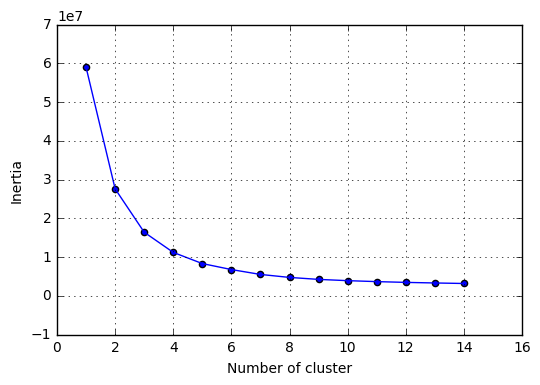

In [47]:
plt.figure()
plt.plot(list(cluster_dict.keys()), list(cluster_dict.values()))
plt.scatter(list(cluster_dict.keys()), list(cluster_dict.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
# for i in range(1, 15):
#     plt.scatter(centroids[0], centroids[1], s=200, c='g', marker='s')
#     plt.scatter(2.01559419, 2.02597093, s=200, c='r', marker='s')
plt.grid()
plt.show()

In [48]:
centroids=bow_km_clf.cluster_centers_
centroids

array([[1.19932838e-04, 0.00000000e+00, 1.19932838e-04, ...,
        0.00000000e+00, 0.00000000e+00, 2.03692732e+01],
       [9.19963201e-04, 9.19963201e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.06322907e+02],
       [0.00000000e+00, 3.51246927e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.40273973e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.38549618e-04, 4.94730439e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.37943730e+02],
       [1.91828122e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.91828122e-04, 0.00000000e+00, 3.81317859e+01]])

In [105]:
BoW_dict['X_train_vect'].shape

(40000, 39622)

In [106]:
bow_final_clf = KMeans(n_clusters = 6, n_jobs = -1)
bow_final_clf.fit(BoW_dict['X_train_vect'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [130]:
from wordcloud import WordCloud
imp_features = []

print("Top terms per cluster:")
order_centroids = bow_final_clf.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
# print(len(terms))
for i in range(6):
    for ind in order_centroids[i, :10]:
        imp_featues_dict = {}
        imp_featues_dict[i] = terms[ind]
        imp_features.append(imp_featues_dict)


Top terms per cluster:
Cluster 0:
Cluster 1:
Cluster 2:
Cluster 3:
Cluster 4:
Cluster 5:


In [164]:
cl1 = [d[0] for d in imp_features if 0 in d]
cl2 = [d[1] for d in imp_features if 1 in d]
cl3 = [d[2] for d in imp_features if 2 in d]
cl4 = [d[3] for d in imp_features if 3 in d]
cl5 = [d[4] for d in imp_features if 4 in d]
cl6 = [d[5] for d in imp_features if 5 in d]
print(cl1, cl2, cl3, cl4, cl5, cl6)

['tea', 'not', 'like', 'flavor', 'great', 'good', 'green', 'teas', 'taste', 'one'] ['not', 'like', 'one', 'would', 'good', 'taste', 'food', 'product', 'no', 'flavor'] ['coffee', 'not', 'cup', 'like', 'good', 'great', 'one', 'flavor', 'best', 'taste'] ['great', 'good', 'not', 'product', 'best', 'love', 'like', 'taste', 'one', 'flavor'] ['not', 'like', 'good', 'taste', 'one', 'great', 'would', 'product', 'flavor', 'get'] ['tea', 'not', 'teas', 'green', 'organic', 'like', 'black', 'tazo', 'good', 'taste']


In [165]:
cl1_string = ' '.join(cl1)
cl2_string = ' '.join(cl2)
cl3_string = ' '.join(cl3)
cl4_string = ' '.join(cl4)
cl5_string = ' '.join(cl5)
cl6_string = ' '.join(cl6)

In [166]:
print(cl1_string)

tea not like flavor great good green teas taste one


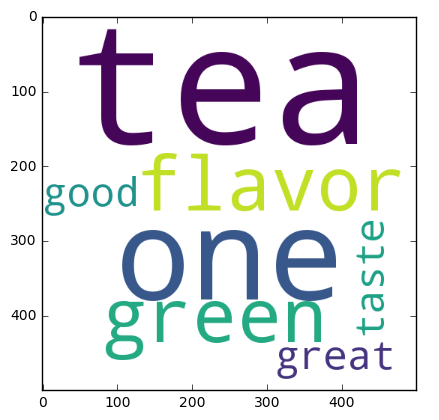

In [177]:
from wordcloud import WordCloud

wordcloud_cluster1 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl1_string)
wordcloud_cluster2 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl2_string)
wordcloud_cluster3 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl3_string)
wordcloud_cluster4 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl4_string)
wordcloud_cluster5 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl5_string)
wordcloud_cluster6 = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(cl6_string)

# plot the WordCloud image
plt.imshow(wordcloud_cluster1)
plt.tight_layout(pad = 0)
plt.show()

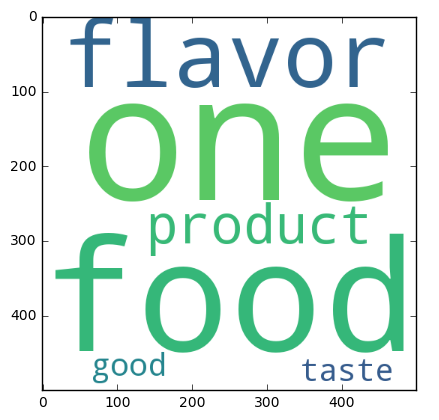

In [178]:
plt.imshow(wordcloud_cluster2)
plt.tight_layout(pad = 0)
plt.show()

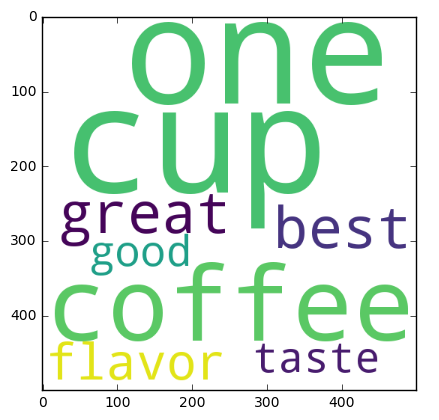

In [179]:
plt.imshow(wordcloud_cluster3)
plt.tight_layout(pad = 0)
plt.show()

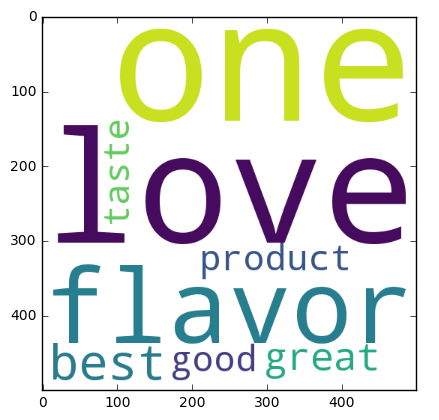

In [180]:
plt.imshow(wordcloud_cluster4)
plt.tight_layout(pad = 0)
plt.show()

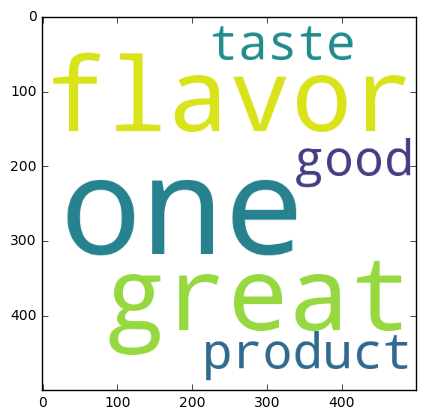

In [181]:
plt.imshow(wordcloud_cluster5)
plt.tight_layout(pad = 0)
plt.show()

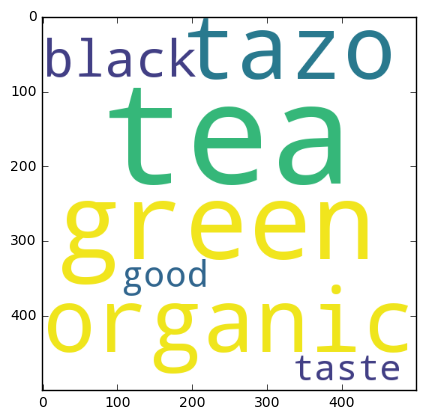

In [182]:
plt.imshow(wordcloud_cluster6)
plt.tight_layout(pad = 0)
plt.show()